In [2]:
# pip install mpl_finance

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import Analyzer

C:\Anaconda\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [4]:
mk = Analyzer.MarketDB()
df = mk.get_daily_price('엔씨소프트', '2017-01-01')

end_date is initialized to '2020-10-05'


In [5]:
ema60 = df.close.ewm(span=60).mean()   # 종가의 12주 지수 이동평균
ema130 = df.close.ewm(span=130).mean() # 종가의 26주 지수 이동평균
macd = ema60 - ema130                  # MACD선
signal = macd.ewm(span=45).mean()      # 신호선(MACD의 9주 지수 이동평균)
macdhist = macd - signal               # MACD 히스토그램

In [6]:
df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal,
    macdhist=macdhist).dropna() 
df['number'] = df.index.map(mdates.date2num)
ohlc = df[['number','open','high','low','close']]

In [9]:
ndays_high = df.high.rolling(window=14, min_periods=1).max()
ndays_low = df.low.rolling(window=14, min_periods=1).min()

In [10]:
fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100
slow_d = fast_k.rolling(window=3).mean()
df = df.assign(fast_k=fast_k, slow_d=slow_d).dropna()

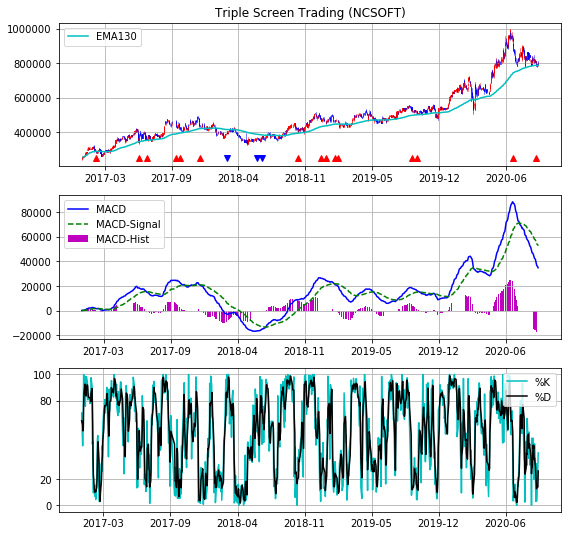

In [13]:
plt.figure(figsize=(9, 9))
p1 = plt.subplot(3, 1, 1)
plt.title('Triple Screen Trading (NCSOFT)')
plt.grid(True)

# 첫 번째 창
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color='c', label='EMA130')
for i in range(1, len(df.close)):
    if df.ema130.values[i-1] < df.ema130.values[i] and \
        df.slow_d.values[i-1] >= 20 and df.slow_d.values[i] < 20:
        plt.plot(df.number.values[i], 250000, 'r^') 
    elif df.ema130.values[i-1] > df.ema130.values[i] and \
        df.slow_d.values[i-1] <= 80 and df.slow_d.values[i] > 80:
        plt.plot(df.number.values[i], 250000, 'bv') 
plt.legend(loc='best')

# 두 번째 창
p2 = plt.subplot(3, 1, 2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.number, df['macdhist'], color='m', label='MACD-Hist')
plt.plot(df.number, df['macd'], color='b', label='MACD')
plt.plot(df.number, df['signal'], 'g--', label='MACD-Signal')
plt.legend(loc='best')

# 세 번째 창
p3 = plt.subplot(3, 1, 3)
plt.grid(True)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['fast_k'], color='c', label='%K')
plt.plot(df.number, df['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100])
plt.legend(loc='best')
plt.show()

    EMA 130 그래프가 오르고 있고, %D가 20 아래로 떨어질 때 매수
    EMA 130 그래프가 하락하고, %D가 80 위로 올라갈 때 매도